### <B>SIMPLE CHATBOT USING LANGGRAPH</B> 

This is a simple chatbot equipped with tool calling, persistent memory and human-in-the-loop-interactivity. Giving it also the capability to unwind changes if necessary and explore different outcomes by going back to previous states in graph using the checkpoints.

<b>Setting up the environment variables for language model and search tool</b>

In [3]:
# Import the required packages here
from dotenv import load_dotenv
import os

# Load the variables from the .env file into the environment
load_dotenv()
os.environ["GEMINI_API_KEY"] = os.getenv("GEMINI_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["COHERE_TRIAL_API_KEY"] = os.getenv("COHERE_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

<b>Importing Necessary Libraries</b> 

In [5]:
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated
from typing_extensions import TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_cohere import ChatCohere
from langchain_core.messages import BaseMessage

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_core.pydantic_v1 import BaseModel
from langchain_core.messages import ToolMessage, AIMessage

<b>Building Our Agent Logic In Graph Form</b>

In [21]:
# We define the state of the graph which is the expected input and output to every node in graph
class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool     

# Inheriting from Pydantic BaseModel making it available as tool to be used by llm in case the llm needs human assistance
class RequestAssistance(BaseModel):
    request: str        

# llm is also given a search tool so that it can give answers even if the query is not in its training data
# this also helps in reducing hallucination somewhat
tool = TavilySearchResults(max_results=2)
tools = [tool]              
llm = ChatCohere()

# bind llm with the above defined tools
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

# defining the chatbot node 
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False

    if(response.tool_calls and response.tool_calls[0]["name"] == RequestAssistance.__name__):
        ask_human = True
        return {"messages": [response], "ask_human": ask_human}

# Use Stategraph to build graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

# In case a human assistance was called we need to return human response in format which the llm expects upon a tool call.
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(content=response, tool_call_id=ai_message.tool_calls[0]["id"],)

# human node this simply sends back us back to chatbot node
def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        new_messages.append(create_response("No human response", state["messages"][-1]))
    
    return {"messages": new_messages, "ask_human": False}

graph_builder.add_node("human", human_node)

# Encoding the logic for conditional edge which decides whether to go to human, search bar or end the conversation.
def select_next_node(state: State):
    if state["ask_human"]:
        return  "human"
    return tools_condition(state)

graph_builder.add_conditional_edges("chatbot", select_next_node, {"human": "human", "tools": "tools", "__end__": "__end__"})

# adding the normal edges
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

# while compiling we provide the memory where to save, we can use Sqlite or PostgresServer 
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["human"])      # manual interrupt before human

After interrupting execution, expert can mnually update the state of graph using <b>"update_state()"</b> function, after which we can resume the eecution.

<b>Displaying Graph Topology</b>

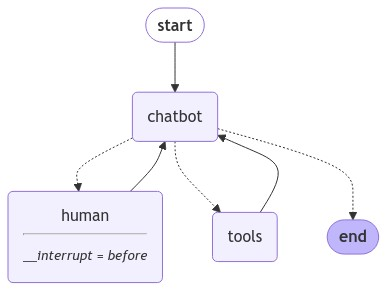

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

<b>Inferencing Our Logic</b>

In [23]:
user_input = "Seek some expert advice for how to learn langgraph"
config = {"configurable": {"thread_id": "1"}}
events = graph.stream({"messages": [("user", user_input)]}, config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Seek some expert advice for how to learn langgraph
================================== Ai Message ==================================

I will ask an expert for advice on how to learn langgraph.
Tool Calls:
  RequestAssistance (8d548d9b254041a7aba6ae6183dd35e9)
 Call ID: 8d548d9b254041a7aba6ae6183dd35e9
  Args:
    request: How can I learn langgraph?


<b>Confirming our graph current state</b>

In [24]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

<b>We act as an expert and send back a tool message</b>

Tool message because request assistance is also used as a tool.

In [25]:
ai_message = snapshot.values["messages"][-1]
human_response = ("Experts: Checkout the documentation")

# passing ai_message is compulsory to keep track of tool id
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef7269c-143c-6611-8002-e4b3023c6bae'}}

In [26]:
graph.get_state(config).values["messages"]

[HumanMessage(content='Seek some expert advice for how to learn langgraph', id='fa132580-95d4-4f56-9742-f4970d2582a3'),
 AIMessage(content='I will ask an expert for advice on how to learn langgraph.', additional_kwargs={'documents': None, 'citations': None, 'search_results': None, 'search_queries': None, 'is_search_required': None, 'generation_id': '9d6c19ff-fd50-44e6-bc71-2d2fccfb6da8', 'tool_calls': [{'id': '9d2142ca4881442db0aa71b4a0ac0877', 'function': {'name': 'RequestAssistance', 'arguments': '{"request": "How can I learn langgraph?"}'}, 'type': 'function'}], 'token_count': {'input_tokens': 965.0, 'output_tokens': 61.0}}, response_metadata={'documents': None, 'citations': None, 'search_results': None, 'search_queries': None, 'is_search_required': None, 'generation_id': '9d6c19ff-fd50-44e6-bc71-2d2fccfb6da8', 'tool_calls': [{'id': '9d2142ca4881442db0aa71b4a0ac0877', 'function': {'name': 'RequestAssistance', 'arguments': '{"request": "How can I learn langgraph?"}'}, 'type': 'functi

Next, resume the graph by invoking it with <b>None</b> as the inputs.

In [27]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

Experts: Checkout the documentation
